<a href="https://colab.research.google.com/github/cleysonl/Pytorch/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [0]:
# Chain transformations 
# 1)transforms.ToTensor(): Convert our numpy array in the range of 0 to 256 to a tensor in a range of 0 to 1
# 2)transforms.Normalize: Normalize the values for each tensor of image size, channel, height and width. Change the range from 0 to 1 to -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ),(0.5, ))
                                ])
training_dataset = datasets.MNIST(root='./data', train=True, download = True, transform=transform)
# Training loader is used to divide the dataset in batches
training_loader = torch.utils.data.DataLoader(dataset= training_dataset, batch_size=100, shuffle=True)

In [0]:
# Plot a tensor image (color, width, height)
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  # transpose to (width,height, color)
  image = image.transpose(1, 2, 0)
  print(image.shape)
  # image = image * np.array((0.5, )) + np.array((0.5, ))
  # We need to get rid of the third dimension 
  image = image[:,:,0]
  # To ensure that the range of the image is between 0 and 1
  image = image.clip(0,1)
  return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


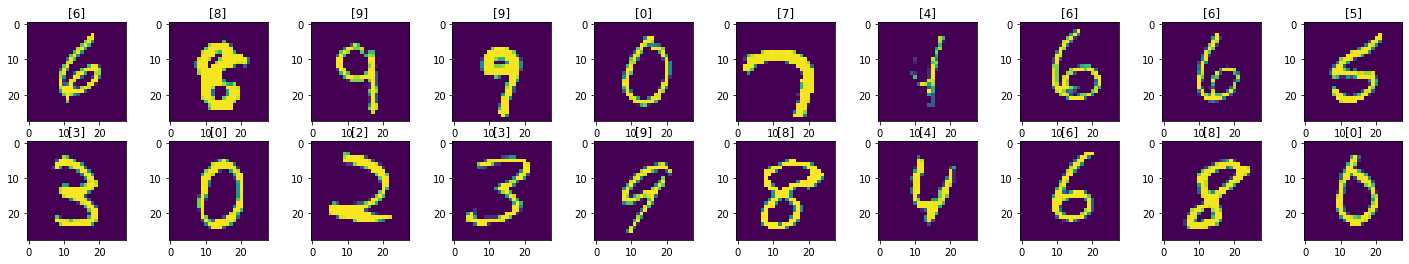

In [5]:
dataiter= iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25,4))

for idx in np.arange(20):
  ax= fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])